<a href="https://colab.research.google.com/github/NeuroTechBSB/BR41N.IO-2025/blob/main/ecog_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing some suggested pipelines

# Library used to return all file paths names that match a specific pattern (helps to open files in a chosen directory)
from glob import glob # help using glob: https://builtin.com/software-engineering-perspectives/glob-in-python

# MNE lybrary to handle ECoG data
!pip install mne
from mne_bids import BIDSPath, read_raw_bids
from mne.viz import plot_alignment, snapshot_brain_montage

# Usefull python libraries to do data analysis/visualizations
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# Keras is a deep learning API capable of running on top of TensorFlow
import keras
from keras import layers

# Library for machine learning and artificial intelligence
import tensorflow as tf

# Library for machine learning
from sklearn import preprocessing, model_selection

In [ ]:
# Uploading the data files locally in the Google Drive space
from google.colab import files
files.upload() #this will prompt you to upload a file locally into the Google Drive (temporally for the session)

## Alternatively (if want to use a already downloaded file in Google Drive):
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/drive/MyDrive/FILE.zip /content
# %%capture
# !unzip /content/FILE.zip -d data


In [ ]:
# Usefull functions (that I know and I think can be useful for this analysis, though not in the pipeline rn)

!unzip FILE.zip # Unzipping a FILE.zip
!pwd # checking currently folder
!ls # to know which files are located in a directory
%cd # perminantly and explictly change the current path
!cd # command ONLY temporarily changes the current path during the one line shell script is running. After that, the IPython intepreter will inplictly change back to the ‘original’ directory
!mkdir # make a new directory (ex: !mkdir /content/name_directory)
files = os.listdir('FILE') # returns a list containing the names of the files within the given directory
print(FILE) # visualize a file
print(type(FILE)) # visualize a file type/extension
FILE.head()

# set search path and glob for files
# here we want to look for csv files in the input directory
path = 'input'
files = glob.glob(path + '/*.csv')

df = pd.read_csv(r'FILE.csv') # to read a .csv file
print(df)

df = (df - df.mean()) / df.std() # to normalize data


In [ ]:
## Loading and pre-processing the data
# Using as references:
 # (1) https://mne.tools/stable/auto_tutorials/clinical/30_ecog.html  (for the MNE-related documentation for processing ECoG)
 # (2) https://github.com/talhaanwarch/youtube-tutorials/blob/main/BCI_Competition_IV.ipynb  (for some of the pre-processing steps)

########## verify the information of the stimulus in our project (this example is using a epilepsy dataset, so we need to adapt it to what we have)
# first define the bids path. This will create the structure to organize the dataset info
bids_path = BIDSPath(
    root=bids_root,
    subject="pt1",
    session="presurgery",
    task="ictal",
    datatype="ieeg",
    extension=".vhdr",
)

# Then we'll use it to load in the sample dataset. This function changes the units of some channels, so we suppress a related warning here by using verbose='error'.
raw = read_raw_bids(bids_path=bids_path, verbose="error")

# Pick only the ECoG channels, removing the EKG channels
raw.pick(picks="ecog")

# Load the data
raw.load_data()

# Check for events info
events = mne.events_from_annotations(raw)

# Remove line frequency interference
raw.notch_filter([60], trans_bandwidth=3) # verify if the power line frequency on the dataset is 60Hz or 50Hz (it depends on the country the data was recorded)

# drop bad channels
raw.drop_channels(raw.info["bads"])

# the coordinate frame of the montage
montage = raw.get_montage()
print(montage.get_positions()["coord_frame"])

# add fiducials to montage
montage.add_mni_fiducials(subjects_dir) # subjects_dir = location of the subject file

# now with fiducials assigned, the montage will be properly converted to "head" which is what MNE requires internally (this is the coordinate
# system with the origin between LPA and RPA whereas MNI has the origin at the posterior commissure)
raw.set_montage(montage)

# Make a 25 second epoch that spans before and after the stimulus onset ########## verify the time of the stimulus in our project
epoch_length = 25  # seconds
epochs = mne.Epochs(
    raw,
    event_id="onset",
    tmin=13,
    tmax=13 + epoch_length,
    baseline=None,
)
# Make evoked from the one epoch and resample
evoked = epochs.average().resample(200)
del epochs

# Check epochs shape
epochs.get_data().shape

# Creating evoked potentials (can be useful)
evoked_stimulus = epochs['Stimulus'].average()


In [ ]:
# Suggestion for a SVM classification model (YET TO ADAPT TO THE DATASET OF THE PROJECT).
# Using as references:
 # (1) https://keras.io/examples/timeseries/eeg_signal_classification/   (using only some useful functions from this pipeine)
 # (2) https://www.kaggle.com/code/oliverright/eeg-brain-signals-emotion-classification   (using only some useful functions from this pipeine)
 # (3) https://www.kaggle.com/code/parhammostame/eeg-eye-state-classification-using-kernel-svm  (using the SVM model proposed)

print(FILE["label"].unique(), "\n") # Show the unique labels of the dataset
print(len(FILE["label"].unique()), "\n") # Show how much of unique labels is within the dataset

# separate targets so you can preprocess the EEG data easily ##### ADAPT
Y = df['eyeDetection']
print( Y.shape )
X = df.drop(columns='eyeDetection')
print( X.shape )
X.head()

###### train and test a Kernel SVM ################3

# train an SVM to classify
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# split train test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=48, test_size=0.2, stratify=Y, shuffle=True)

# Showing how many data in the test and in the training group
print(
    f"Length of x_train : {len(x_train)}\nLength of x_test : {len(x_test)}\nLength of y_train : {len(y_train)}\nLength of y_test : {len(y_test)}"
)

# normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.metrics import roc_auc_score
# train with grid search
svc = SVC()
parameters = {'gamma': [0.1, 1, 10], 'C': [0.1, 1, 10]}
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

# predict labels
y_pred = clf.predict(X_test)

# extract accuracy (r2 score)
results = roc_auc_score(y_test, y_pred)

# print score
print( 'Score is: ' + str( results ) )
print( 'Best params for the kernel SVM is: ' + str(clf.best_params_) )

##### Confusion matrix ##############3

from sklearn.metrics import confusion_matrix

# confusion matrix estimation
conf = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8,6))
sns.heatmap(conf, annot=True, cmap='seismic', annot_kws={'fontsize':18})
_ = plt.title( 'AUC score: ' + str(round(results, 2) ), fontsize=15)
_ = plt.xticks(ticks=[0.5, 1.5], labels=['Eyes-closed', 'Eyes-open'])
_ = plt.yticks(ticks=[0.5, 1.5], labels=['Eyes-closed', 'Eyes-open'])
_ = plt.ylabel('True label', fontsize=15)
_ = plt.xlabel('Predicted label', fontsize=15)

# Load and inspect data: 

In [9]:
import scipy.io as sio
import numpy as np
import pandas as pd
import mne

In [2]:
# Load the .mat file
mat = sio.loadmat('ECoG_Handpose.mat')

# Inspect keys
print("Available keys in mat:", mat.keys())

Available keys in mat: dict_keys(['__header__', '__version__', '__globals__', 'y'])


In [ ]:
y = mat['y']  # shape (67, 507025)

# 1b. Define channel names and types
sfreq = 1200.0
ch_names = (
    ['time'] +
    [f'ecog{ch:02d}' for ch in range(1, 61)] +
    ['stim'] +
    ['glove_thumb','glove_index','glove_middle','glove_ring','glove_little']
)
ch_types = (
    ['misc'] +
    ['ecog'] * 60 +
    ['stim'] +
    ['misc'] * 5
)


In [10]:
# 1c. Create RawArray
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(y, info)

# ======================================
# 2. Pre-processing: notch filter & reference
# ======================================
raw.notch_filter(freqs=[60], picks='ecog', trans_bandwidth=3)  
raw.set_eeg_reference(ref_channels='average', projection=False)  

# ======================================
# 3. Find events on the 'stim' channel
# ======================================
#   This will detect rising edges where stim goes 0→1,2 or 3
events = mne.find_events(raw, stim_channel='stim', shortest_event=1)
# Inspect first few events: (sample_index, 0, event_id)
print("First events:", events[:5])


Creating RawArray with float64 data, n_channels=67, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 58 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 58.35
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 57.60 Hz)
- Upper passband edge: 61.65 Hz
- Upper transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 62.40 Hz)
- Filter length: 2641 samples (2.201 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.
90 events found on stim channel stim
Event IDs: [1 2 3]
First events: [[14496     0     3]
 [20256     0     1]
 [26112     0     3]
 [31680     0     2]
 [37440     0     2]]


In [26]:
# 3bis. Detect all stim changes, including relax=0

import numpy as np

# get the index of the 'stim' channel
stim_idx = raw.ch_names.index('stim')

# retrieve the stim channel data by index
stim = raw.get_data(picks=[stim_idx])[0]  

# find every sample where the value changes
change_idx = np.where(np.diff(stim) != 0)[0] + 1  

# the new event code is the stim value after the change
event_codes = stim[change_idx].astype(int)

# build the MNE-compatible events array: [sample, 0, code]
events_all = np.column_stack([
    change_idx,
    np.zeros_like(change_idx, dtype=int),
    event_codes
])

print("Detected codes:", np.unique(event_codes))
# Should print: [0 1 2 3]

Detected codes: [0 1 2 3]


In [28]:
event_id_all = {
    'relax': 0,
    'fist' : 1,
    'peace': 2,
    'open' : 3
}

tmin, tmax = 0.0, 2.0
epochs_all = mne.Epochs(
    raw,
    events=events_all,
    event_id=event_id_all,
    tmin=tmin,
    tmax=tmax,
    baseline=None,
    preload=True
)

# keep only the ECoG channels (correct pick call)
epochs_all.pick_types(ecog=True)

print("Epochs shape with relax included:", epochs_all.get_data().shape)


Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 180 events and 2401 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Epochs shape with relax included: (180, 60, 2401)


In [29]:
# ======================================
# 5bis. Extract features from each epoch (including relax)
# ======================================
import numpy as np
import pandas as pd

data_all = epochs_all.get_data()  
n_epochs_all, n_channels, n_times = data_all.shape
print(f"All data shape: epochs={n_epochs_all}, channels={n_channels}, samples={n_times}")

feat_list = []
label_list = []

for i in range(n_epochs_all):
    epoch = data_all[i]
    means = epoch.mean(axis=1)
    stds  = epoch.std(axis=1)
    rmss  = np.sqrt((epoch**2).mean(axis=1))
    feat = np.concatenate([means, stds, rmss])
    feat_list.append(feat)
    label_list.append(int(epochs_all.events[i, 2]))

cols = []
for ch in range(1, n_channels+1):
    cols += [f"ch{ch:02d}_mean", f"ch{ch:02d}_std", f"ch{ch:02d}_rms"]

df_all = pd.DataFrame(feat_list, columns=cols)
df_all['label'] = label_list

print("DataFrame (with relax) shape:", df_all.shape)
df_all['label'].value_counts()


All data shape: epochs=180, channels=60, samples=2401
DataFrame (with relax) shape: (180, 181)


label
0    90
3    30
1    30
2    30
Name: count, dtype: int64

In [ ]:
# Data frame structure
# 1. Shape, dtypes and missing values
print("Shape:", df_all.shape)
print("\nData types:\n", df_all.dtypes)
print("\nMissing values per column:\n", df_all.isnull().sum())

# 2. First few rows
display(df_all.head())

# 3. Basic statistics for numeric features
display(df_all.describe())

# 4. Label distribution
print("\nLabel counts:\n", df_all['label'].value_counts())


Shape: (180, 181)

Data types:
 ch01_mean    float64
ch01_std     float64
ch01_rms     float64
ch02_mean    float64
ch02_std     float64
              ...   
ch59_rms     float64
ch60_mean    float64
ch60_std     float64
ch60_rms     float64
label          int64
Length: 181, dtype: object

Missing values per column:
 ch01_mean    0
ch01_std     0
ch01_rms     0
ch02_mean    0
ch02_std     0
            ..
ch59_rms     0
ch60_mean    0
ch60_std     0
ch60_rms     0
label        0
Length: 181, dtype: int64


,ch01_mean,ch01_std,ch01_rms,ch02_mean,ch02_std,ch02_rms,ch03_mean,ch03_std,ch03_rms,ch04_mean,...,ch58_mean,ch58_std,ch58_rms,ch59_mean,ch59_std,ch59_rms,ch60_mean,ch60_std,ch60_rms,label
0,-81751.684766,-54906.783248,-51534.150503,-78002.770407,-34839.092233,-15133.224904,10933.992226,68423.827946,33831.725341,14065.532529,...,44946.414555,71198.422343,8916.341478,1163.144828,3530.814155,40391.388898,7242.414440,24606.077161,76757.685157,3
1,-81746.245791,-54937.435299,-51507.437642,-78036.159305,-34822.448667,-15168.322188,11141.790481,68317.123440,33925.557423,14048.722120,...,44975.222676,71206.927173,8937.041799,1123.799143,3504.844688,40397.826937,7263.968667,24595.243433,76734.113321,0
2,-81807.491400,-55083.739442,-51538.943469,-78068.558343,-34861.009343,-15194.780372,11017.914118,68314.907846,33815.023767,14003.591756,...,45068.507372,71279.495470,8854.133471,1021.946453,3569.321942,40453.617950,7333.460405,24570.856217,76695.255361,1
3,-81865.281666,-55201.378376,-51571.864794,-78106.182137,-34956.025083,-15290.738002,10734.732630,68314.238047,33699.024495,13964.382698,...,45122.865413,71325.905035,8800.379028,988.041139,3555.082427,40507.679484,7417.094083,24526.976058,76614.809937,0
4,-82004.473326,-55422.842672,-51640.824022,-78173.420668,-35053.539783,-15418.861243,10453.912786,68343.935281,33401.618790,13926.096609,...,45223.656482,71405.688412,8749.947986,936.204788,3624.762181,40602.895225,7465.050334,24419.227257,76501.625817,3


,ch01_mean,ch01_std,ch01_rms,ch02_mean,ch02_std,ch02_rms,ch03_mean,ch03_std,ch03_rms,ch04_mean,...,ch58_mean,ch58_std,ch58_rms,ch59_mean,ch59_std,ch59_rms,ch60_mean,ch60_std,ch60_rms,label
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,...,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,-82629.467315,-59206.206462,-51064.479730,-78313.139097,-35322.307434,-15120.821711,12290.807238,69737.496282,37733.972239,14364.799336,...,45314.987353,71291.087505,10276.156119,2447.915281,3669.598073,40233.209007,7676.122229,22782.493817,76566.199134,1.000000
std,768.697659,1569.011651,275.931368,242.988990,738.647520,780.643404,1455.344897,1106.216952,1781.077727,664.261051,...,141.339430,302.175747,719.499004,1113.570542,490.960671,249.025415,505.267387,1131.800697,177.372334,1.157921
min,-83690.453161,-61094.283203,-51649.684151,-78792.760629,-36729.696957,-16692.286513,9169.767753,67751.466245,33238.983233,13095.239187,...,44946.414555,70754.471885,8739.855039,872.275305,2432.904651,39765.711067,6894.279035,21024.809519,76222.737916,0.000000
25%,-83461.626808,-60598.657594,-51237.081398,-78519.880352,-35928.144744,-15850.219134,11119.848982,68722.719037,36529.472173,13765.326541,...,45207.762245,71003.964423,9847.179681,1392.239748,3299.354514,40013.936266,7257.815149,21620.090489,76436.825229,0.000000
50%,-82607.503025,-59591.761114,-51075.862497,-78282.931902,-35161.629664,-14888.806429,12833.949175,69843.232697,38130.751329,14645.155308,...,45327.854418,71364.759019,10296.917341,2271.920266,3751.768150,40273.199746,7509.261868,22632.078660,76572.989133,0.500000
75%,-82079.513256,-58413.944489,-50838.361163,-78134.705129,-34865.532666,-14463.110153,13378.638172,70577.468640,39318.628299,14865.447349,...,45423.216007,71561.583836,10657.934209,3360.225119,4111.694946,40426.066424,8156.186510,23901.062912,76658.090041,2.000000
max,-81276.553729,-54906.783248,-50622.541480,-77897.149916,-34151.371522,-14176.286947,14452.457564,71925.632287,39886.704270,15269.111160,...,45634.654677,71830.296730,11597.111339,4551.150560,4360.223770,40652.088579,8639.082539,24606.077161,77049.641389,3.000000



Label counts:
 label
0    90
3    30
1    30
2    30
Name: count, dtype: int64


# 1. Correlation Matrix of Channel Means
The heatmap above shows the pairwise Pearson correlation coefficients between the mean amplitudes of all 60 ECoG channels across the 90 epochs. Warm colors (reds) indicate strong positive correlation, while cool colors (blues) indicate negative correlation. We can see two clusters of highly inter-correlated channels: one roughly covering channels 1–20 and another around channels 40–60, suggesting spatially adjacent electrodes pick up similar activity patterns. The middle channels (21–39) show weaker correlations overall, hinting at potentially different signal dynamics in that region.





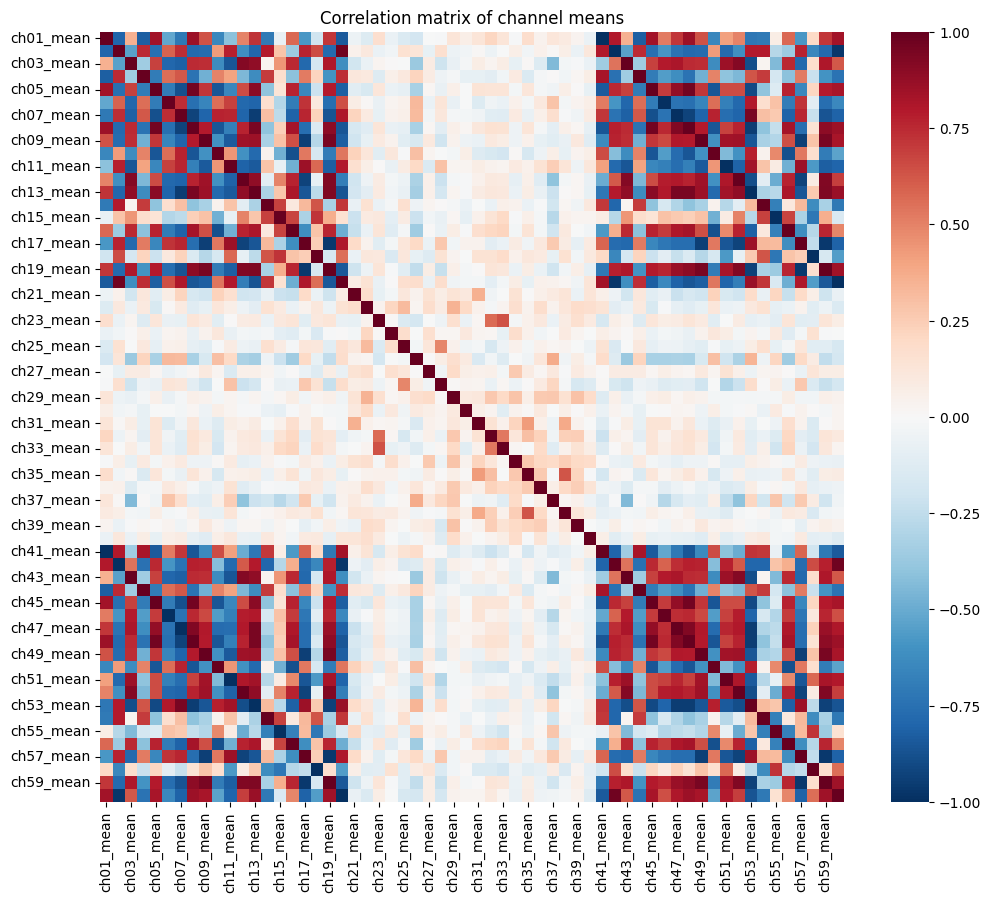

In [34]:
# ======================================
# 7. Correlation heatmap of channel means
# ======================================
import matplotlib.pyplot as plt
import seaborn as sns

# select only the mean features
mean_cols = [col for col in df_all.columns if col.endswith('_mean')]

# compute correlation matrix
corr_means = df_all[mean_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_means, center=0, cmap='RdBu_r')
plt.title('Correlation matrix of channel means')
plt.show()


# 2. Channel 01 Mean by Gesture Label
This boxplot compares the distribution of the mean amplitude on channel 01 for each gesture class (0= relax, 1=fist, 2=peace, 3=open). Although all three distributions overlap substantially, note that the “open” hand (label 3) tends to have slightly higher median mean-amplitude and a wider interquartile range, whereas the “peace” gesture (label 2) appears to sit lowest on average. Such subtle shifts may be exploitable by a classifier to distinguish gestures.


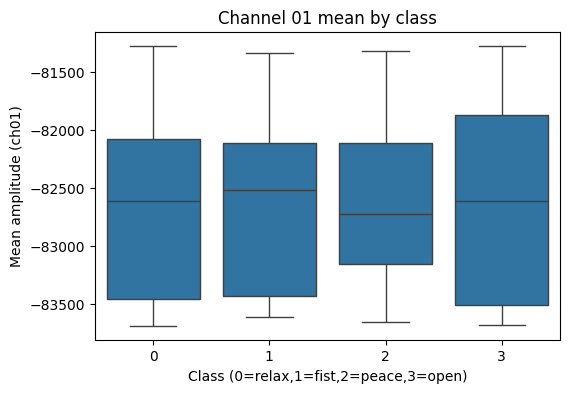

In [35]:

# ======================================
# 8. Boxplot of channel 01 mean by label
# ======================================
plt.figure(figsize=(6, 4))
sns.boxplot(x='label', y='ch01_mean', data=df_all)
plt.title('Channel 01 mean by class')
plt.xlabel('Class (0=relax,1=fist,2=peace,3=open)')
plt.ylabel('Mean amplitude (ch01)')
plt.show()



# 3. Pairwise Relationships for Channels 1–3 Means
The pairplot displays three channels’ mean amplitudes against each other and their univariate distributions, colored by gesture. The diagonal KDE plots show that the distributions of each channel mean are broadly similar across gestures, but there are slight visible shifts (e.g., channel 3 shows a bimodal tendency). The off-diagonal scatter plots hint at some weak linear structure—points cluster differently for each label—but also significant overlap, indicating these three features alone won’t perfectly separate all classes.

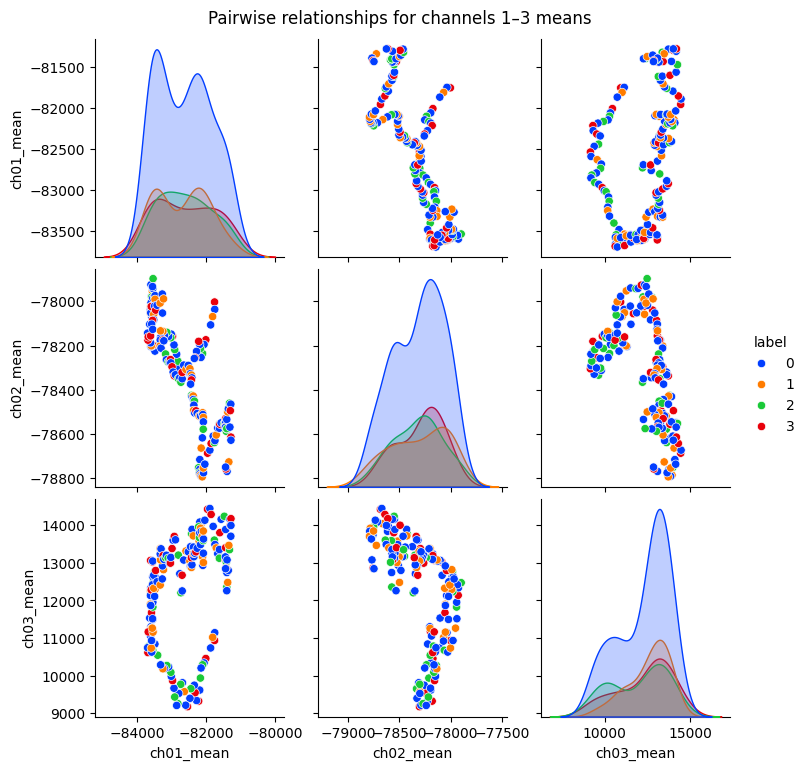

In [36]:
# ======================================
# 9. Pairplot for channels 1–3 means
# ======================================
sns.pairplot(df_all, 
             vars=['ch01_mean','ch02_mean','ch03_mean'], 
             hue='label', 
             palette='bright')
plt.suptitle('Pairwise relationships for channels 1–3 means', y=1.02)
plt.show()


# 4. Violin Plots of Channel 01, 30, and 60 RMS by Gesture
The violin plots illustrate the full RMS-amplitude distributions of channels 01, 30, and 60 across the three gestures. Channel 01 (left) again shows a slight shift in center for gesture 3 (open), whereas channels 30 and 60 (middle and right) exhibit more subtle differences: channel 30’s RMS distribution for open hand extends to higher values, and channel 60 appears almost identical for all gestures. These plots confirm that RMS features vary by channel and gesture, but some channels carry more discriminative information than others.


C:\Users\cesar\AppData\Local\Temp\ipykernel_23228\778985103.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


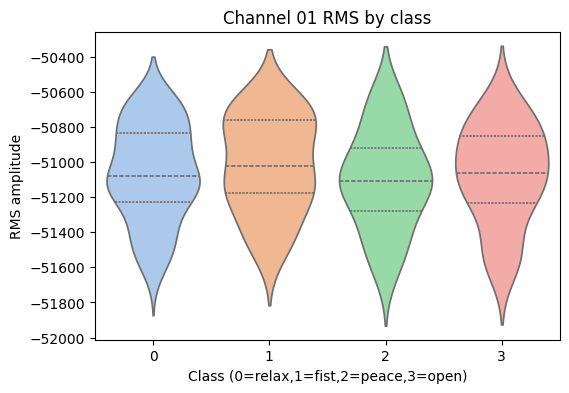

C:\Users\cesar\AppData\Local\Temp\ipykernel_23228\778985103.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


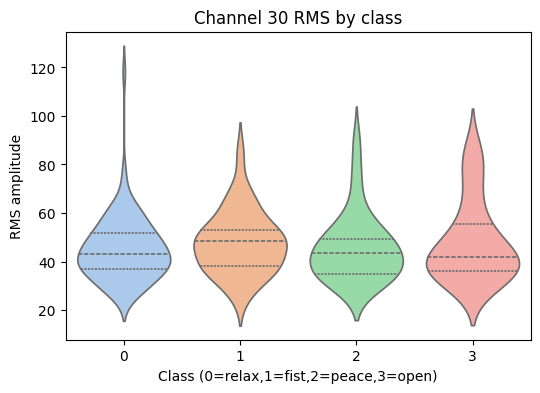

C:\Users\cesar\AppData\Local\Temp\ipykernel_23228\778985103.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


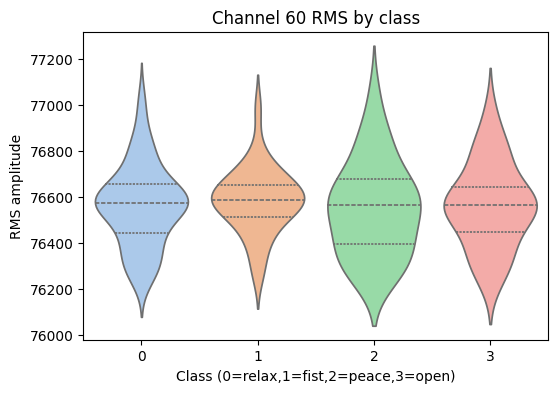

In [37]:
# ======================================
# 10. Violin plots for RMS of channels 1, 30, 60
# ======================================
for ch in [1, 30, 60]:
    plt.figure(figsize=(6,4))
    sns.violinplot(
        x='label',
        y=f'ch{ch:02d}_rms',
        data=df_all,
        inner='quartile',
        palette='pastel'
    )
    plt.title(f'Channel {ch:02d} RMS by class')
    plt.xlabel('Class (0=relax,1=fist,2=peace,3=open)')
    plt.ylabel('RMS amplitude')
    plt.show()

# 5. PCA (2 Components) of ECoG Features
In this scatter of the first two principal components (PC1 vs. PC2), each point represents one epoch’s 180-dimensional feature vector projected down to 2D. Although the three gesture classes (colors) are not perfectly separable, you can see two rough “arms” of points: one cluster on the right and one on the left, each containing mixed labels. This suggests that a linear subspace captures some variance related to gesture, but additional components or nonlinear modeling may be needed to fully discriminate.

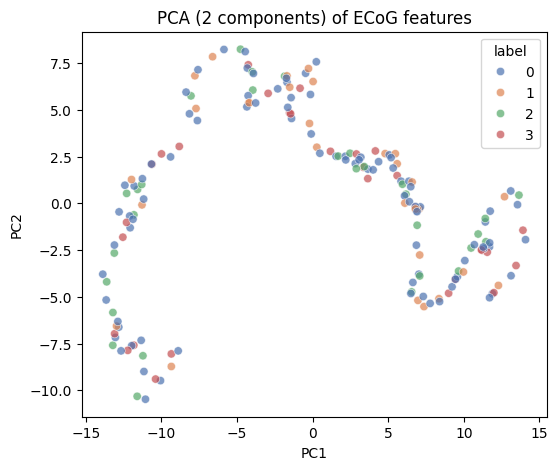

In [38]:
# 11. PCA (2 components) of all features
# ======================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Prepare data
X_all = df_all.drop(columns='label')
y_all = df_all['label']
X_scaled = StandardScaler().fit_transform(X_all)

# PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=pcs[:,0], y=pcs[:,1],
    hue=y_all,
    palette='deep',
    alpha=0.7
)
plt.title('PCA (2 components) of ECoG features')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


# 6. Average Time Course of Channel 01 per Gesture
This line plot shows the mean time-series (over 2 s post-cue) for channel 01, averaged separately for each gesture. Gesture 1 (fist) begins at the lowest baseline and exhibits a small rising trend, whereas gestures 2 (peace) and 3 (open) start higher and remain relatively flat. These temporal differences—particularly the rising deflection around 0.2–0.5 s in the fist trials—could be leveraged by time-sensitive models (e.g., CNN, LSTM) to improve classification.

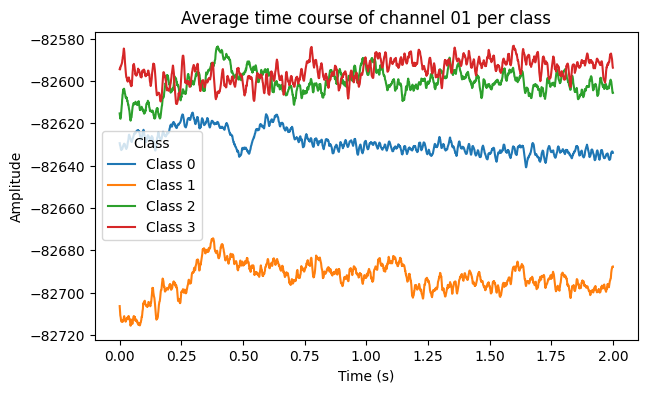

In [39]:
# ======================================
# 12. Average time course of channel 01 per class
# ======================================
times = epochs_all.times
data_all = epochs_all.get_data()  # shape (180, 60, samples)

plt.figure(figsize=(7,4))
for cls in sorted(df_all['label'].unique()):
    idx = np.where(df_all['label']==cls)[0]
    mean_ts = data_all[idx, 0, :].mean(axis=0)
    plt.plot(times, mean_ts, label=f'Class {cls}')
plt.legend(title='Class')
plt.title('Average time course of channel 01 per class')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# 7. Mean of First 20 Features per Gesture (Heatmap)
Here we plot the class-wise means of the first 20 features (i.e., the means, stds, and RMS for channels 1–7) for each gesture. Each row is a gesture (1–3) and each column a feature. Notice that for ch03_mean and ch07_std, gesture 3 (open) consistently shows higher values, while gesture 2 (peace) often has the lowest. This summary highlights which individual features differ most between classes and can guide feature selection or channel weighting in downstream models.

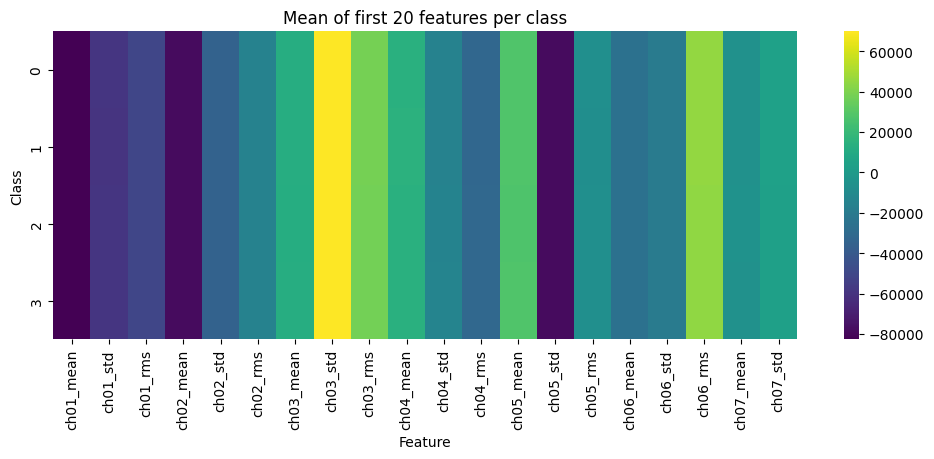

In [40]:
# ======================================
# 13. Heatmap of feature means for first 20 features per class
# ======================================
class_means = df_all.groupby('label').mean()

plt.figure(figsize=(12,4))
sns.heatmap(
    class_means.iloc[:, :20],
    cmap='viridis',
    annot=False
)
plt.title('Mean of first 20 features per class')
plt.xlabel('Feature')
plt.ylabel('Class')
plt.show()

In [42]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

# 1. Separate features and labels
X = df_all.drop(columns='label')
y = df_all['label']

# 2. Standardize features to mean=0, var=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Encode labels as integers (0–3)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Inspect mapping and shapes
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", mapping)
print("X_scaled shape:", X_scaled.shape)
print("y_encoded shape:", y_encoded.shape)

# Optional: build a DataFrame to inspect the first rows
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['label_encoded'] = y_encoded
display(df_scaled.head())


Label mapping: {0: 0, 1: 1, 2: 2, 3: 3}
X_scaled shape: (180, 180)
y_encoded shape: (180,)


,ch01_mean,ch01_std,ch01_rms,ch02_mean,ch02_std,ch02_rms,ch03_mean,ch03_std,ch03_rms,ch04_mean,...,ch58_mean,ch58_std,ch58_rms,ch59_mean,ch59_std,ch59_rms,ch60_mean,ch60_std,ch60_rms,label_encoded
0,1.145094,2.747855,-1.706877,1.280858,0.656014,-0.015933,-0.934898,-1.190845,-2.197058,-0.451783,...,-2.614988,-0.307515,-1.895218,-1.156958,-0.283467,0.636968,-0.860767,1.615717,1.082582,3
1,1.152189,2.728264,-1.609797,1.143066,0.678609,-0.061018,-0.791717,-1.287573,-2.144229,-0.477160,...,-2.410597,-0.279291,-1.866368,-1.192389,-0.336510,0.662893,-0.817989,1.606119,0.949317,0
2,1.072293,2.634758,-1.724295,1.009358,0.626259,-0.095005,-0.877073,-1.289581,-2.206462,-0.545290,...,-1.748751,-0.038469,-1.981920,-1.284109,-0.204814,0.887555,-0.680071,1.584511,0.729630,1
3,0.996903,2.559573,-1.843938,0.854089,0.497266,-0.218269,-1.072196,-1.290188,-2.271772,-0.604482,...,-1.363086,0.115544,-2.056839,-1.314642,-0.233899,1.105253,-0.514086,1.545633,0.274825,0
4,0.815324,2.418030,-2.094550,0.576603,0.364880,-0.382852,-1.265692,-1.263268,-2.439219,-0.662279,...,-0.647984,0.380310,-2.127126,-1.361321,-0.091578,1.488673,-0.418908,1.450166,-0.365071,3


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Split train+val vs. final test (10% held out)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled,          # scaled features
    y_encoded,         # encoded labels
    test_size=0.10,
    random_state=42,
    stratify=y_encoded
)

# 2. Split train vs. val (20% of the train_val for validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.20,
    random_state=42,
    stratify=y_train_val
)

print(f"Sizes → Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")



Sizes → Train: 129, Val: 33, Test: 18


## 1. Prediction 

**Targets:** chanels CH63–CH67 (thumb, index, middle, ring, little)  
**Models:** Ridge, SVR, Random Forest, GBM, XGBoost, MLP, Stacking  
**Metrich:** MSE, MAE, R² 


In this case I choose to separate the targets in the five fingers a

In [47]:
import numpy as np
import pandas as pd

# 1. Recupera la matriz y de scipy.loadmat
y_mat = mat['y']            # shape = (67, n_samples)
y_mat = y_mat.reshape(67, -1)

# 2. Parámetros de epoching
sfreq = raw.info['sfreq']   # debería ser 1200
samples_per_epoch = int((tmax - tmin) * sfreq) + 1  # 2401

# 3. Extrae índices de evento
event_samples = events_all[:, 0]

# 4. Construye glove_data manualmente
n_epochs = len(event_samples)
glove_data = np.zeros((n_epochs, 5, samples_per_epoch))

for i, s in enumerate(event_samples):
    # toma filas 62–66 de y_mat: CH63–CH67
    glove_data[i] = y_mat[62:67, s : s + samples_per_epoch]

# 5. Calcula la media temporal por dedo
y_glove = glove_data.mean(axis=2)  # shape (n_epochs, 5)

# 6. Pasa a DataFrame
df_glove = pd.DataFrame(
    y_glove,
    columns=['thumb','index','middle','ring','little']
)
print("Glove DataFrame shape:", df_glove.shape)
display(df_glove.head())
from sklearn.model_selection import train_test_split

# 1) Split train+val vs. final test, estratificando por gesto
X_train_val, X_test, y_train_val, y_test, enc_train_val, enc_test = train_test_split(
    X_scaled,      # features
    df_glove,      # targets continuos (5 dedos)
    y_encoded,     # etiquetas de gesto (0–3)
    test_size=0.10,
    random_state=42,
    stratify=y_encoded
)

# 2) Split train vs. val, estratificando por el subconjunto de etiquetas de gesto
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.20,
    random_state=42,
    stratify=enc_train_val
)

print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val:   X={X_val.shape},   y={y_val.shape}")
print(f"Test:  X={X_test.shape},  y={y_test.shape}")



Glove DataFrame shape: (180, 5)


,thumb,index,middle,ring,little
0,0.364385,0.092923,0.121410,0.385116,0.118718
1,0.518437,0.015632,0.071171,0.252271,0.050578
2,0.524889,0.595959,0.412113,0.712141,0.598800
3,0.601336,0.244937,0.223812,0.435934,0.247653
4,0.675521,0.036789,0.056976,0.255398,0.032521


Train: X=(129, 180), y=(129, 5)
Val:   X=(33, 180),   y=(33, 5)
Test:  X=(18, 180),  y=(18, 5)


# 1 Regression

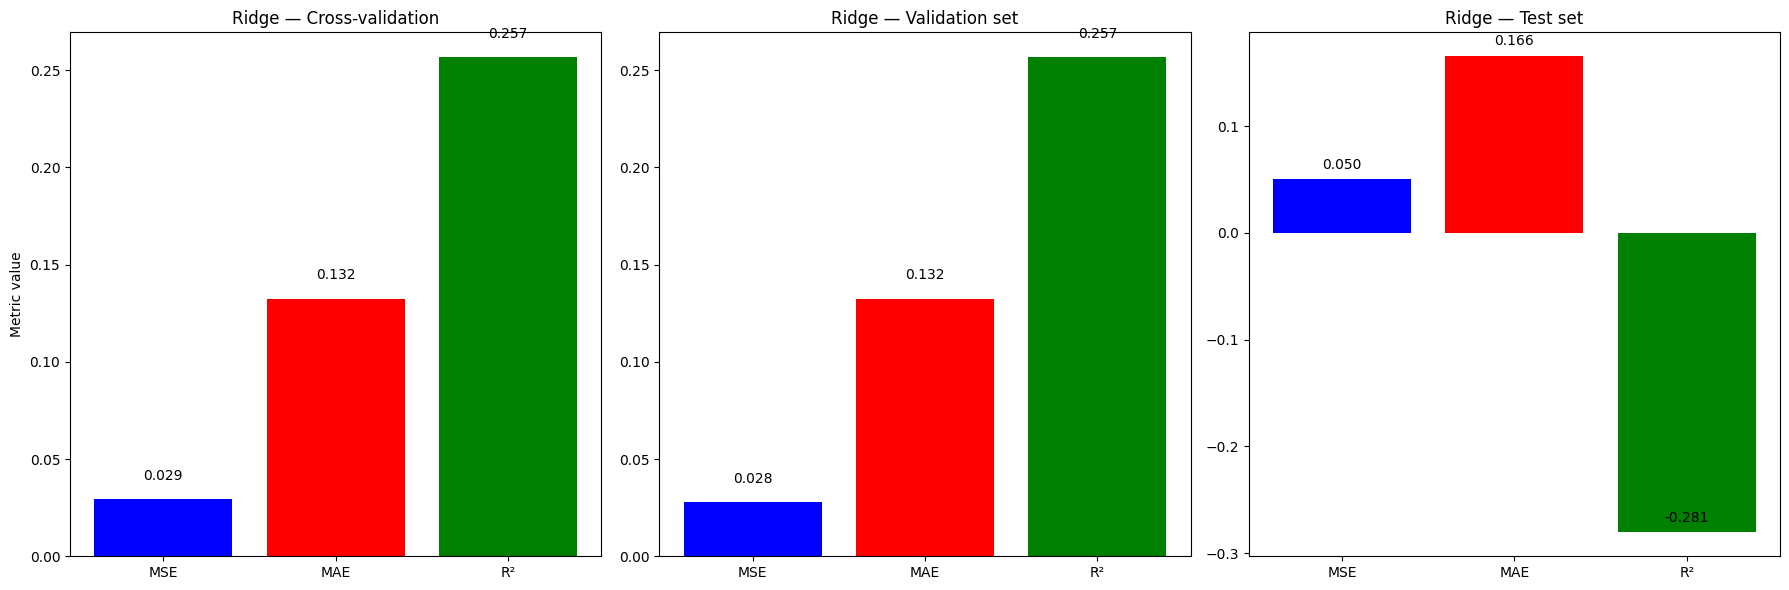

Ridge Regression Performance
Validation → MSE: 0.028, MAE: 0.132, R²: 0.257
Test       → MSE: 0.050, MAE: 0.166, R²: -0.281
Best Params: {'estimator__alpha': 26.366508987303554, 'estimator__fit_intercept': True}


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Wrap Ridge in MultiOutputRegressor ---
mor = MultiOutputRegressor(Ridge())

# Hyper‐parameters to search
param_grid = {
    'estimator__alpha': np.logspace(-3, 3, 20),
    'estimator__fit_intercept': [True, False]
}

# --- 2. GridSearchCV over the multi‐output model ---
grid_search = GridSearchCV(
    mor,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_ridge = grid_search.best_estimator_

# --- 3. Cross‐validation on the TRAIN split ---
cv_results = cross_validate(
    best_ridge,
    X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=False
)

# --- 4. Evaluate on VAL and TEST splits ---
# Validation
y_pred_val = best_ridge.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val  = r2_score(y_val, y_pred_val)

# Test
y_pred_test = best_ridge.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test  = r2_score(y_test, y_pred_test)

# --- 5. Plot risultato metrics ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# CV
axes[0].bar(
    ['MSE','MAE','R²'],
    [-np.mean(cv_results['test_score']), mae_val, r2_val],
    color=['b','r','g']
)
axes[0].set_title('Ridge — Cross-validation')
axes[0].set_ylabel('Metric value')
for i, v in enumerate([-np.mean(cv_results['test_score']), mae_val, r2_val]):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Validation
axes[1].bar(['MSE','MAE','R²'], [mse_val, mae_val, r2_val], color=['b','r','g'])
axes[1].set_title('Ridge — Validation set')
for i, v in enumerate([mse_val, mae_val, r2_val]):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Test
axes[2].bar(['MSE','MAE','R²'], [mse_test, mae_test, r2_test], color=['b','r','g'])
axes[2].set_title('Ridge — Test set')
for i, v in enumerate([mse_test, mae_test, r2_test]):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# --- 6. Print summary ---
print("Ridge Regression Performance")
print(f"Validation → MSE: {mse_val:.3f}, MAE: {mae_val:.3f}, R²: {r2_val:.3f}")
print(f"Test       → MSE: {mse_test:.3f}, MAE: {mae_test:.3f}, R²: {r2_test:.3f}")
print("Best Params:", grid_search.best_params_)


# 2 Xgboost

c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [10:28:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [10:28:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning

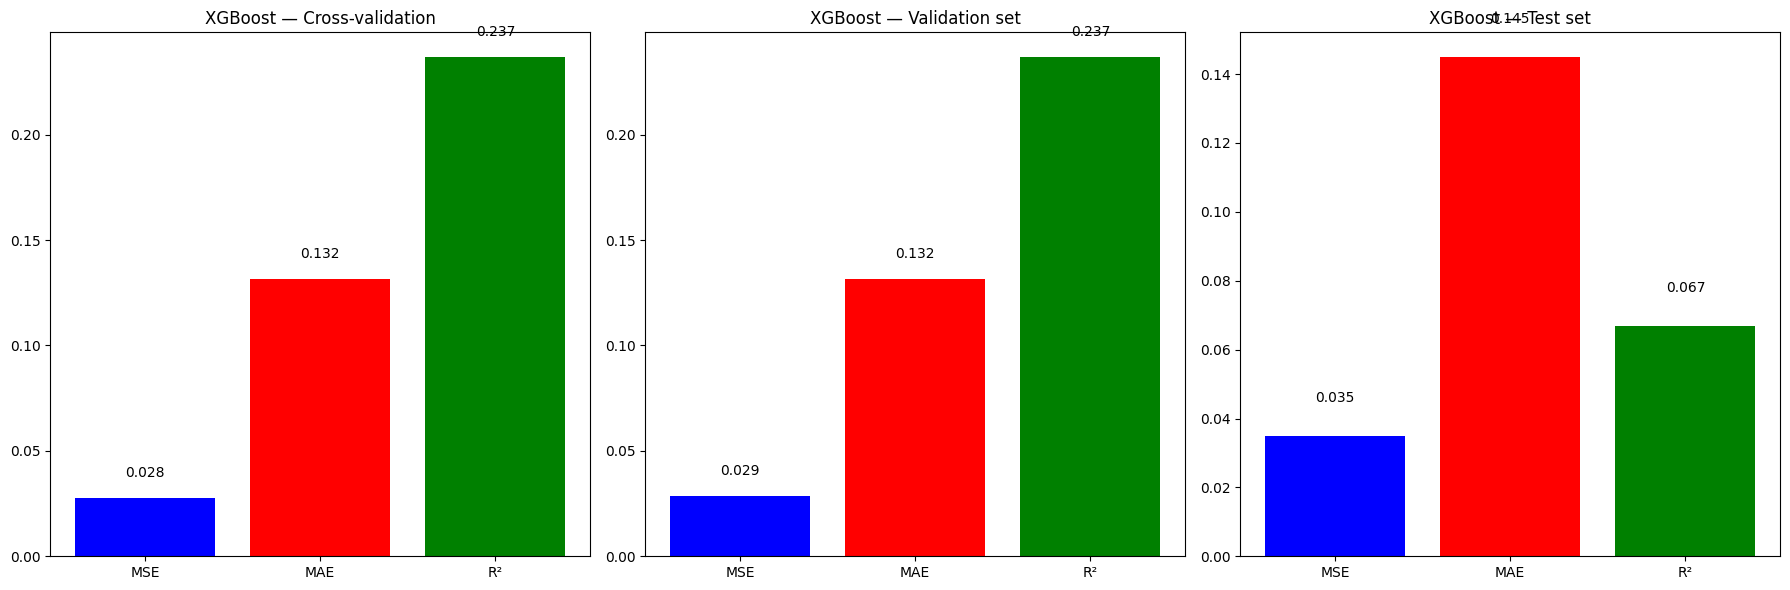

XGBoost Regression Performance
Validation → MSE: 0.029, MAE: 0.132, R²: 0.237
Test       → MSE: 0.035, MAE: 0.145, R²: 0.067
Best params: {'estimator__colsample_bytree': 0.8, 'estimator__gamma': 0, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 200, 'estimator__subsample': 1.0}


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Envuelvo XGBRegressor para multi-salida y activo GPU
base_xgb = XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42,
    verbosity=0
)
mor_xgb = MultiOutputRegressor(base_xgb)

# 2) Defino la malla de hiperparámetros
param_grid = {
    'estimator__n_estimators':    [50, 100, 200],
    'estimator__max_depth':       [3, 5, 10],
    'estimator__learning_rate':   [0.01, 0.1, 0.2],
    'estimator__subsample':       [0.8, 1.0],
    'estimator__colsample_bytree':[0.8, 1.0],
    'estimator__gamma':           [0, 0.1, 0.2]
}

# 3) GridSearchCV sobre el conjunto de entrenamiento (X_train, y_train)
grid_search_xgb = GridSearchCV(
    mor_xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

# 4) Cross-validate en TRAIN
cv_results = cross_validate(
    best_xgb, X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=False
)

# 5) Métricas en VALIDATION
y_pred_val = best_xgb.predict(X_val)
mse_val  = mean_squared_error(y_val, y_pred_val)
mae_val  = mean_absolute_error(y_val, y_pred_val)
r2_val   = r2_score(y_val, y_pred_val)

# 6) Métricas en TEST
y_pred_test = best_xgb.predict(X_test)
mse_test    = mean_squared_error(y_test, y_pred_test)
mae_test    = mean_absolute_error(y_test, y_pred_test)
r2_test     = r2_score(y_test, y_pred_test)

# 7) Plots de comparación
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].bar(
    ['MSE','MAE','R²'],
    [-np.mean(cv_results['test_score']), mae_val, r2_val],
    color=['b','r','g']
)
axes[0].set_title('XGBoost — Cross-validation')
for i, v in enumerate([-np.mean(cv_results['test_score']), mae_val, r2_val]):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

axes[1].bar(['MSE','MAE','R²'], [mse_val, mae_val, r2_val], color=['b','r','g'])
axes[1].set_title('XGBoost — Validation set')
for i, v in enumerate([mse_val, mae_val, r2_val]):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

axes[2].bar(['MSE','MAE','R²'], [mse_test, mae_test, r2_test], color=['b','r','g'])
axes[2].set_title('XGBoost — Test set')
for i, v in enumerate([mse_test, mae_test, r2_test]):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# 8) Resumen numérico
print("XGBoost Regression Performance")
print(f"Validation → MSE: {mse_val:.3f}, MAE: {mae_val:.3f}, R²: {r2_val:.3f}")
print(f"Test       → MSE: {mse_test:.3f}, MAE: {mae_test:.3f}, R²: {r2_test:.3f}")
print("Best params:", grid_search_xgb.best_params_)


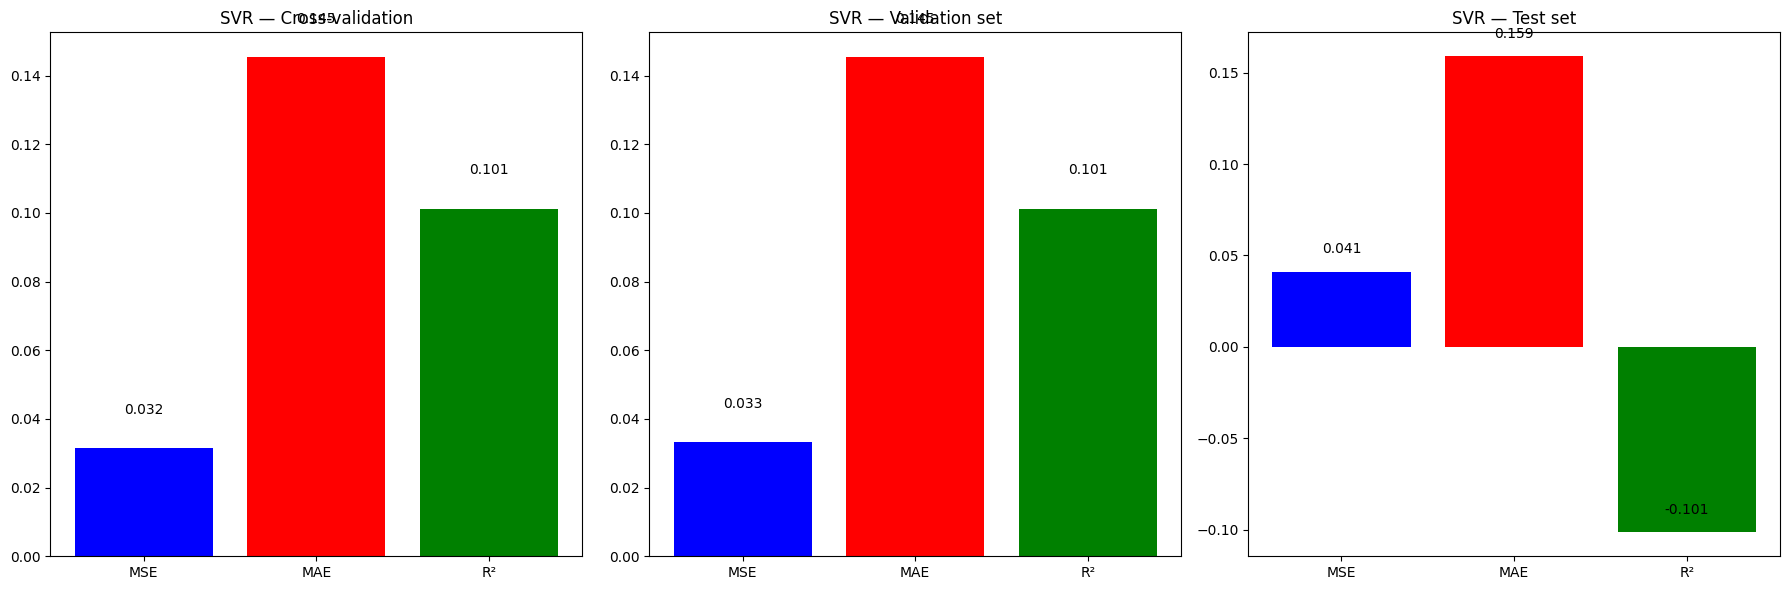

SVR Regression Performance
Validation → MSE: 0.033, MAE: 0.145, R²: 0.101
Test       → MSE: 0.041, MAE: 0.159, R²: -0.101
Best SVR params: {'estimator__C': 1, 'estimator__epsilon': 0.01, 'estimator__kernel': 'rbf'}


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Envuelve SVR para multi-output
mor_svm = MultiOutputRegressor(
    SVR()  # ejecutará en CPU
)

# 2) Malla de hiperparámetros
param_grid = {
    'estimator__C':       [0.1, 1, 10],
    'estimator__epsilon': [0.01, 0.1, 0.2],
    'estimator__kernel':  ['linear', 'rbf']
}

# 3) GridSearch sobre el conjunto de entrenamiento
grid_search_svm = GridSearchCV(
    mor_svm,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_

# 4) Cross-validate en TRAIN
cv_results = cross_validate(
    best_svm, X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=False
)

# 5) Métricas en VALIDATION
y_pred_val = best_svm.predict(X_val)
mse_val  = mean_squared_error(y_val, y_pred_val)
mae_val  = mean_absolute_error(y_val, y_pred_val)
r2_val   = r2_score(y_val, y_pred_val)

# 6) Métricas en TEST
y_pred_test = best_svm.predict(X_test)
mse_test    = mean_squared_error(y_test, y_pred_test)
mae_test    = mean_absolute_error(y_test, y_pred_test)
r2_test     = r2_score(y_test, y_pred_test)

# 7) Plot de resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# CV
axes[0].bar(
    ['MSE','MAE','R²'],
    [-np.mean(cv_results['test_score']), mae_val, r2_val],
    color=['b','r','g']
)
axes[0].set_title('SVR — Cross-validation')
for i, v in enumerate([-np.mean(cv_results['test_score']), mae_val, r2_val]):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Validation
axes[1].bar(['MSE','MAE','R²'], [mse_val, mae_val, r2_val], color=['b','r','g'])
axes[1].set_title('SVR — Validation set')
for i, v in enumerate([mse_val, mae_val, r2_val]):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Test
axes[2].bar(['MSE','MAE','R²'], [mse_test, mae_test, r2_test], color=['b','r','g'])
axes[2].set_title('SVR — Test set')
for i, v in enumerate([mse_test, mae_test, r2_test]):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# 8) Resumen
print("SVR Regression Performance")
print(f"Validation → MSE: {mse_val:.3f}, MAE: {mae_val:.3f}, R²: {r2_val:.3f}")
print(f"Test       → MSE: {mse_test:.3f}, MAE: {mae_test:.3f}, R²: {r2_test:.3f}")
print("Best SVR params:", grid_search_svm.best_params_)


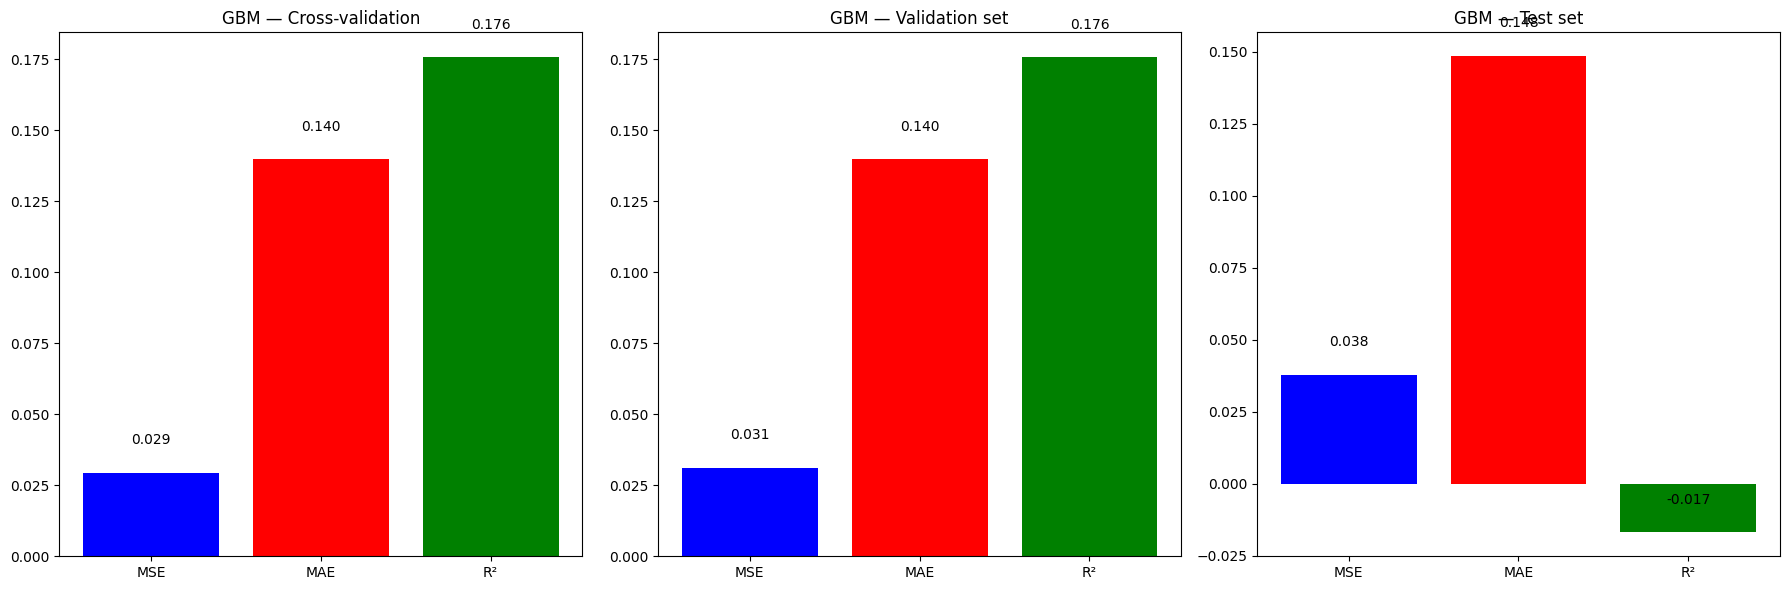

Gradient Boosting Regression Performance
Validation → MSE: 0.031, MAE: 0.140, R²: 0.176
Test       → MSE: 0.038, MAE: 0.148, R²: -0.017
Best GBM parameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 200}


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ======================================
# 1. Wrap GBM for multi-output regression
# ======================================
mor_gbm = MultiOutputRegressor(
    GradientBoostingRegressor(random_state=42)
)

# ======================================
# 2. Hyperparameter grid for GBM
# ======================================
param_grid = {
    'estimator__n_estimators':      [50, 100, 200],
    'estimator__learning_rate':     [0.01, 0.1, 0.2],
    'estimator__max_depth':         [3, 5, 10],
    'estimator__min_samples_split': [2, 5, 10]
}

# ======================================
# 3. GridSearchCV on the training set
# ======================================
grid_search_gbm = GridSearchCV(
    mor_gbm,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_gbm.fit(X_train, y_train)
best_gbm = grid_search_gbm.best_estimator_

# ======================================
# 4. Cross-validation on the TRAIN split
# ======================================
cv_results = cross_validate(
    best_gbm, X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=False
)

# ======================================
# 5. Evaluate on the VALIDATION split
# ======================================
y_pred_val = best_gbm.predict(X_val)
mse_val  = mean_squared_error(y_val, y_pred_val)
mae_val  = mean_absolute_error(y_val, y_pred_val)
r2_val   = r2_score(y_val, y_pred_val)

# ======================================
# 6. Evaluate on the TEST split
# ======================================
y_pred_test = best_gbm.predict(X_test)
mse_test    = mean_squared_error(y_test, y_pred_test)
mae_test    = mean_absolute_error(y_test, y_pred_test)
r2_test     = r2_score(y_test, y_pred_test)

# ======================================
# 7. Plotting results
# ======================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Cross-validation metrics
axes[0].bar(
    ['MSE', 'MAE', 'R²'],
    [-np.mean(cv_results['test_score']), mae_val, r2_val],
    color=['b', 'r', 'g']
)
axes[0].set_title('GBM — Cross-validation')
for i, v in enumerate([-np.mean(cv_results['test_score']), mae_val, r2_val]):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Validation set metrics
axes[1].bar(['MSE', 'MAE', 'R²'], [mse_val, mae_val, r2_val], color=['b', 'r', 'g'])
axes[1].set_title('GBM — Validation set')
for i, v in enumerate([mse_val, mae_val, r2_val]):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Test set metrics
axes[2].bar(['MSE', 'MAE', 'R²'], [mse_test, mae_test, r2_test], color=['b', 'r', 'g'])
axes[2].set_title('GBM — Test set')
for i, v in enumerate([mse_test, mae_test, r2_test]):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# ======================================
# 8. Print summary
# ======================================
print("Gradient Boosting Regression Performance")
print(f"Validation → MSE: {mse_val:.3f}, MAE: {mae_val:.3f}, R²: {r2_val:.3f}")
print(f"Test       → MSE: {mse_test:.3f}, MAE: {mae_test:.3f}, R²: {r2_test:.3f}")
print("Best GBM parameters:", grid_search_gbm.best_params_)


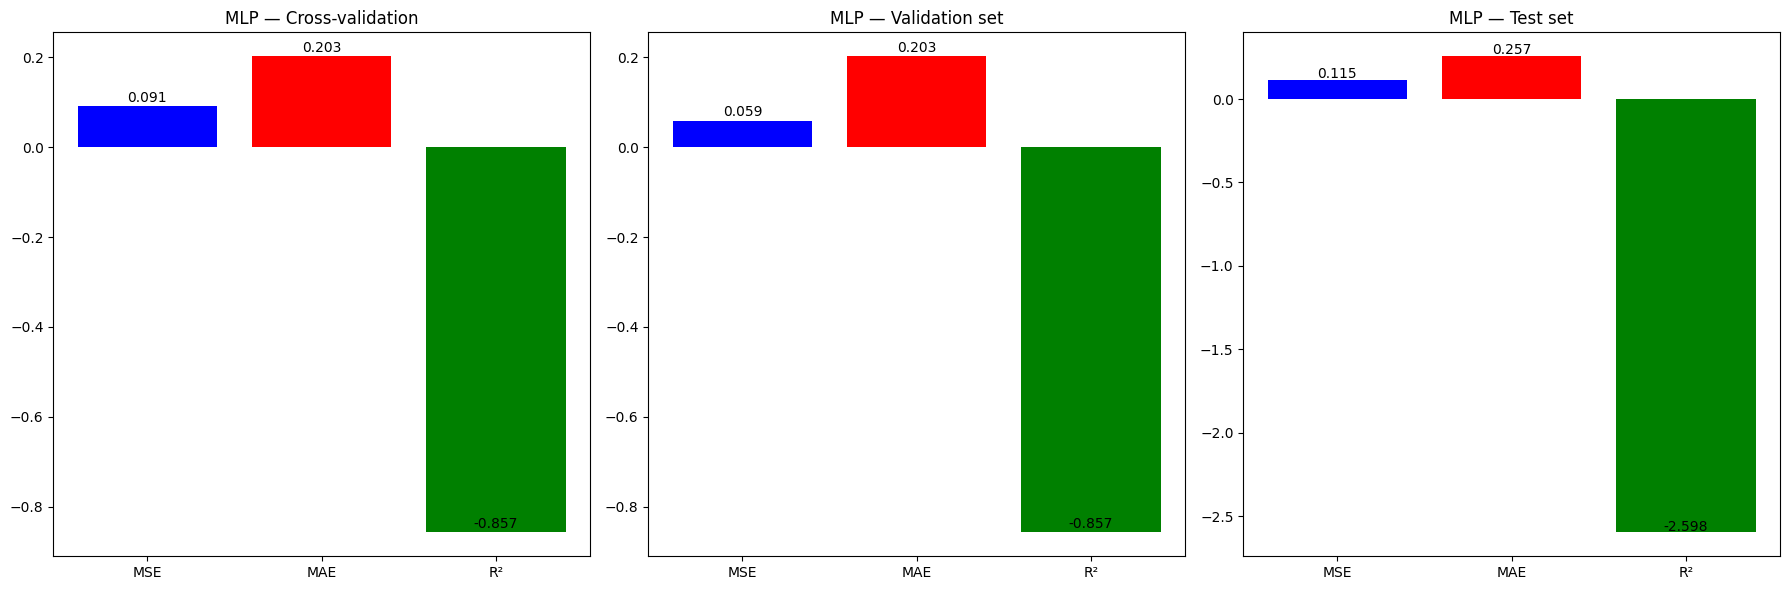

MLP Regression Performance
Validation → MSE: 0.059, MAE: 0.203, R²: -0.857
Test       → MSE: 0.115, MAE: 0.257, R²: -2.598
Best MLP parameters: {'estimator__activation': 'tanh', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (50, 50), 'estimator__learning_rate': 'constant', 'estimator__solver': 'adam'}


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ======================================
# 1. Wrap MLPRegressor for multi-output regression
# ======================================
mor_mlp = MultiOutputRegressor(
    MLPRegressor(random_state=42, max_iter=500)
)

# ======================================
# 2. Define hyperparameter grid
# ======================================
mlp_params = {
    'estimator__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'estimator__activation':         ['relu', 'tanh'],
    'estimator__solver':             ['adam', 'sgd'],
    'estimator__alpha':              [1e-4, 1e-3],
    'estimator__learning_rate':      ['constant', 'invscaling', 'adaptive']
}

# ======================================
# 3. GridSearchCV on the training set
# ======================================
grid_search_mlp = GridSearchCV(
    mor_mlp,
    param_grid=mlp_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_mlp.fit(X_train, y_train)
best_mlp = grid_search_mlp.best_estimator_

# ======================================
# 4. Cross-validation on TRAIN split
# ======================================
cv_results = cross_validate(
    best_mlp, X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=False
)

# ======================================
# 5. Evaluate on VALIDATION split
# ======================================
y_pred_val = best_mlp.predict(X_val)
mse_val    = mean_squared_error(y_val, y_pred_val)
mae_val    = mean_absolute_error(y_val, y_pred_val)
r2_val     = r2_score(y_val, y_pred_val)

# ======================================
# 6. Evaluate on TEST split
# ======================================
y_pred_test = best_mlp.predict(X_test)
mse_test    = mean_squared_error(y_test, y_pred_test)
mae_test    = mean_absolute_error(y_test, y_pred_test)
r2_test     = r2_score(y_test, y_pred_test)

# ======================================
# 7. Plotting results
# ======================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Cross-validation metrics
axes[0].bar(
    ['MSE', 'MAE', 'R²'],
    [-np.mean(cv_results['test_score']), mae_val, r2_val],
    color=['b', 'r', 'g']
)
axes[0].set_title('MLP — Cross-validation')
for i, v in enumerate([-np.mean(cv_results['test_score']), mae_val, r2_val]):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Validation set metrics
axes[1].bar(['MSE', 'MAE', 'R²'], [mse_val, mae_val, r2_val], color=['b', 'r', 'g'])
axes[1].set_title('MLP — Validation set')
for i, v in enumerate([mse_val, mae_val, r2_val]):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Test set metrics
axes[2].bar(['MSE', 'MAE', 'R²'], [mse_test, mae_test, r2_test], color=['b', 'r', 'g'])
axes[2].set_title('MLP — Test set')
for i, v in enumerate([mse_test, mae_test, r2_test]):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# ======================================
# 8. Print summary
# ======================================
print("MLP Regression Performance")
print(f"Validation → MSE: {mse_val:.3f}, MAE: {mae_val:.3f}, R²: {r2_val:.3f}")
print(f"Test       → MSE: {mse_test:.3f}, MAE: {mae_test:.3f}, R²: {r2_test:.3f}")
print("Best MLP parameters:", grid_search_mlp.best_params_)


# deeplearning

In [97]:
!pip install tensorflow==2.12

^C


  Using cached google_auth-2.39.0-py2.py3-none-any.whl.metadata (6.2 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
   ---------------------------------------- 0.0/272.8 MB ? eta -:--:--
   ---------------------------------------- 0.8/272.8 MB 3.7 MB/s eta 0:01:14
   ---------------------------------------- 1.0/272.8 MB 2.4 MB/s eta 0:01:54
   ---------------------------------------- 1.3/272.8 MB 2.4 MB/s eta 0:01:54
   ---------------------------------------- 1.8/272.8 MB 2.1 MB/s eta 0:02:10
   ---------------------------------------- 2.1/272.8 MB 2.1 MB/s eta 0:02:07
   ---------------------------------------- 2.6/272.8 MB 2.0 MB/s eta 0:02:13
   ---------------------------------------- 2.9/272.8 MB 2.0 MB/s eta 0:02:16
   ---------------------------------------- 3.4/272.8 MB 2.0 MB/s eta 0:02:16
    ------------------------------

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\cesar\\anaconda3\\envs\\pytorch\\Lib\\site-packages\\tensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Consider using the `--user` option or check the permissions.



In [93]:

indices = np.arange(X_scaled.shape[0])
from sklearn.model_selection import train_test_split

# 1) Train+Val vs Test
X_train_val, X_test, y_train_val, y_test, enc_train_val, enc_test, idx_train_val, idx_test = train_test_split(
    X_scaled, df_glove, y_encoded, indices,
    test_size=0.10, random_state=42, stratify=y_encoded
)

# 2) Train vs Val
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_val, y_train_val, idx_train_val,
    test_size=0.20, random_state=42, stratify=enc_train_val
)


In [96]:
import tensorflow as tf
print("Dispositivos físicos:", tf.config.list_physical_devices('GPU'))


Dispositivos físicos: []


In [98]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# ========== GPU CONFIG ==========
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU is being used.")
    except RuntimeError as e:
        print("❌ GPU setup failed:", e)

# ========== Datos crudos ==========
X_raw_epochs = data_all.astype(np.float32)                    # Shape: (n_epochs, 60, 2401)
X_raw_cnn = X_raw_epochs[..., np.newaxis]                     # Shape: (n_epochs, 60, 2401, 1)
y_glove_np = y_glove.astype(np.float32)                       # Shape: (n_epochs, 5)

# ========== División ==========
X_train_cnn = X_raw_cnn[idx_train]
X_val_cnn   = X_raw_cnn[idx_val]
X_test_cnn  = X_raw_cnn[idx_test]

y_train_cnn = y_glove_np[idx_train]
y_val_cnn   = y_glove_np[idx_val]
y_test_cnn  = y_glove_np[idx_test]

# ========== Modelo 1D-CNN ==========
input_shape = (60, 2401, 1)

cnn_model = models.Sequential([
    layers.Conv2D(32, (1, 50), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((1, 4)),
    layers.Conv2D(64, (1, 25), activation='relu'),
    layers.MaxPooling2D((1, 4)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5)
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# ========== Entrenamiento ==========
history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=50,
    batch_size=16,
    verbose=1
)

# ========== Evaluación ==========
test_loss, test_mae = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print(f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 543ms/step - loss: 308918059008.0000 - mae: 214008.1875 - val_loss: 136049632.0000 - val_mae: 10217.1621
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 66230048.0000 - mae: 6488.3770 - val_loss: 3993512.0000 - val_mae: 1736.3085
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 3630411.2500 - mae: 1476.7642 - val_loss: 275810.8750 - val_mae: 438.2298
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 545ms/step - loss: 164347.2031 - mae: 341.1514 - val_loss: 9938.8477 - val_mae: 85.0629
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 536ms/step - loss: 3576.5176 - mae: 34.5223 - val_loss: 0.2086 - val_mae: 0.3403
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 541ms/step - loss: 0.2189 - mae: 0.3466 - val_loss: 0.1699 - val_mae: 0.3317
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 535ms/step - loss: 0.1452 - mae: 0.3103 - val_loss: 0.1719 - val_mae: 0.3307
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - loss: 0.1325 - mae: 0.2894 - val_loss: 0.1769 - val_mae: 0.328

# Transformer Light Model

In [99]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# Ensure raw epochs data is float32 and shaped properly
X_raw_epochs = data_all.astype(np.float32)                 # (n_epochs, 60, 2401)
X_raw_tf = X_raw_epochs                                    # No need to add channel dimension
y_glove_np = y_glove.astype(np.float32)                    # (n_epochs, 5)

# === Use the same precomputed indices as before ===
X_train_tf = X_raw_tf[idx_train]
X_val_tf   = X_raw_tf[idx_val]
X_test_tf  = X_raw_tf[idx_test]

y_train_tf = y_glove_np[idx_train]
y_val_tf   = y_glove_np[idx_val]
y_test_tf  = y_glove_np[idx_test]


In [100]:
# Transformer input shape: (batch, time_steps=2401, features=60)
input_layer = Input(shape=(60, 2401))  # Original shape is (channels, time)
x = layers.Permute((2, 1))(input_layer)  # → (batch, time=2401, features=60)

# Positional encoding could be added here if needed for longer sequences
x = layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
output_layer = layers.Dense(5)(x)  # Output: 5 continuous glove values

transformer_model = models.Model(inputs=input_layer, outputs=output_layer)

transformer_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)


In [101]:
history = transformer_model.fit(
    X_train_tf, y_train_tf,
    validation_data=(X_val_tf, y_val_tf),
    epochs=30,
    batch_size=8,
    verbose=1
)

# Final evaluation
test_loss, test_mae = transformer_model.evaluate(X_test_tf, y_test_tf, verbose=0)
print(f"Transformer Test MSE: {test_loss:.4f}, MAE: {test_mae:.4f}")


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - loss: 16447460.0000 - mae: 3119.7305 - val_loss: 1162571.2500 - val_mae: 1016.1935
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - loss: 708639.8125 - mae: 706.6339 - val_loss: 210279.2656 - val_mae: 372.2567
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - loss: 145641.7500 - mae: 297.9705 - val_loss: 59854.5117 - val_mae: 192.8188
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - loss: 54374.9141 - mae: 182.2608 - val_loss: 36947.8438 - val_mae: 146.4537
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 795ms/step - loss: 32763.4004 - mae: 137.4377 - val_loss: 15270.5859 - val_mae: 101.9891
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 799ms/step - loss: 21460.3262 - mae: 114.8181 - val_loss: 26297.0527 - val_mae: 123.2826
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 783ms/step - loss: 20757.7773 - mae: 114.8139 - val_loss: 15548.4072 - val_mae: 99.0916
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 408ms/step - loss: 18858.5020 - mae: 

# LSTM / BiLSTM (Recurrente)

In [102]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Convert shape from (n_epochs, 60, 2401) → (n_epochs, 2401, 60)
X_lstm = np.transpose(X_raw_epochs, (0, 2, 1))  # now (n_samples, 2401, 60)

# Split using previously defined indices
X_train_lstm = X_lstm[idx_train]
X_val_lstm   = X_lstm[idx_val]
X_test_lstm  = X_lstm[idx_test]

# Targets
y_train_lstm = y_glove_np[idx_train]
y_val_lstm   = y_glove_np[idx_val]
y_test_lstm  = y_glove_np[idx_test]

# Define BiLSTM model
lstm_model = models.Sequential([
    layers.Input(shape=(2401, 60)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(5)  # 5 continuous outputs
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model
lstm_history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=50,
    batch_size=16,
    verbose=1
)

# Evaluate
lstm_loss, lstm_mae = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"BiLSTM → Test MSE: {lstm_loss:.4f}, MAE: {lstm_mae:.4f}")


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - loss: 0.3313 - mae: 0.5075 - val_loss: 0.0534 - val_mae: 0.1948
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - loss: 0.0494 - mae: 0.1862 - val_loss: 0.0552 - val_mae: 0.1838
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - loss: 0.0606 - mae: 0.1899 - val_loss: 0.0408 - val_mae: 0.1588
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - loss: 0.0418 - mae: 0.1686 - val_loss: 0.0415 - val_mae: 0.1737
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - loss: 0.0406 - mae: 0.1679 - val_loss: 0.0396 - val_mae: 0.1566
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - loss: 0.0413 - mae: 0.1609 - val_loss: 0.0374 - val_mae: 0.1546
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - loss: 0.0408 - mae: 0.1651 - val_loss: 0.0382 - val_mae: 0.1650
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - loss: 0.0409 - mae: 0.1742 - val_loss: 0.0381 - val_mae: 0.1613
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - loss: 0.0394 - mae: 

# 2D-CNN

In [103]:
# Add channel dimension to get shape: (n_samples, 60, 2401, 1)
X_cnn2d = X_raw_epochs[..., np.newaxis].astype(np.float32)

# Split according to idx
X_train_cnn2d = X_cnn2d[idx_train]
X_val_cnn2d   = X_cnn2d[idx_val]
X_test_cnn2d  = X_cnn2d[idx_test]

# Targets
y_train_cnn2d = y_glove_np[idx_train]
y_val_cnn2d   = y_glove_np[idx_val]
y_test_cnn2d  = y_glove_np[idx_test]

# Define 2D-CNN model
cnn2d_model = models.Sequential([
    layers.Conv2D(32, (3, 50), activation='relu', input_shape=(60, 2401, 1)),
    layers.MaxPooling2D((2, 4)),
    layers.Conv2D(64, (3, 25), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5)
])

cnn2d_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model
cnn2d_history = cnn2d_model.fit(
    X_train_cnn2d, y_train_cnn2d,
    validation_data=(X_val_cnn2d, y_val_cnn2d),
    epochs=50,
    batch_size=16,
    verbose=1
)

# Evaluate
cnn2d_loss, cnn2d_mae = cnn2d_model.evaluate(X_test_cnn2d, y_test_cnn2d, verbose=0)
print(f"2D-CNN → Test MSE: {cnn2d_loss:.4f}, MAE: {cnn2d_mae:.4f}")


Epoch 1/50


c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 473ms/step - loss: 16252414.0000 - mae: 2671.7852 - val_loss: 540914.1250 - val_mae: 542.6093
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - loss: 805604.3125 - mae: 721.4160 - val_loss: 125572.7734 - val_mae: 228.7206
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - loss: 271967.7188 - mae: 395.1761 - val_loss: 175431.4688 - val_mae: 391.3878
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 464ms/step - loss: 140178.1094 - mae: 332.1904 - val_loss: 73816.7656 - val_mae: 235.6844
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 461ms/step - loss: 54142.1484 - mae: 203.4487 - val_loss: 43127.5273 - val_mae: 184.0105
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step - loss: 25295.3789 - mae: 133.3834 - val_loss: 17058.2500 - val_mae: 114.1370
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 10617.6318 - mae: 87.3738 - val_loss: 11361.9551 - val_mae: 88.0155
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 464ms/step - loss: 6734.0684 - mae: 65.4814 - val_loss: 1481.6281 - va

# Clasification

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


X_tr_val, X_test_clf, y_tr_val, y_test_clf = train_test_split(
    X_scaled, y_encoded,
    test_size=0.10,
    random_state=42,
    stratify=y_encoded
)
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(
    X_tr_val, y_tr_val,
    test_size=0.20,
    random_state=42,
    stratify=y_tr_val
)
print(f"Sizes → Train: {X_train_clf.shape[0]}, Val: {X_val_clf.shape[0]}, Test: {X_test_clf.shape[0]}")

# ==== 1. LDA Baseline ====
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_clf, y_train_clf)

# Predict & evaluate on validation
y_val_pred = lda.predict(X_val_clf)
print("LDA - Validation Accuracy:", accuracy_score(y_val_clf, y_val_pred))
print(confusion_matrix(y_val_clf, y_val_pred))
print(classification_report(y_val_clf, y_val_pred))

# Predict & evaluate on test
y_test_pred = lda.predict(X_test_clf)
print("LDA - Test Accuracy:", accuracy_score(y_test_clf, y_test_pred))
print(confusion_matrix(y_test_clf, y_test_pred))
print(classification_report(y_test_clf, y_test_pred))


Sizes → Train: 129, Val: 33, Test: 18
LDA - Validation Accuracy: 0.18181818181818182
[[1 6 3 7]
 [0 4 1 0]
 [0 4 0 2]
 [1 2 1 1]]
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        17
           1       0.25      0.80      0.38         5
           2       0.00      0.00      0.00         6
           3       0.10      0.20      0.13         5

    accuracy                           0.18        33
   macro avg       0.21      0.26      0.15        33
weighted avg       0.31      0.18      0.13        33

LDA - Test Accuracy: 0.2777777777777778
[[1 3 2 3]
 [0 1 2 0]
 [0 2 1 0]
 [0 0 1 2]]
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.17      0.33      0.22         3
           2       0.17      0.33      0.22         3
           3       0.40      0.67      0.50         3

    accuracy                           0.28        18
   macro avg       0.43 

In [109]:
# ==== División PARA CLASIFICACIÓN de gestos ====
from sklearn.model_selection import train_test_split

# X_scaled y y_encoded vienen de tu preprocesamiento time-domain simple
X_tr_val, X_test_clf, y_tr_val, y_test_clf = train_test_split(
    X_scaled, y_encoded,
    test_size=0.10,
    random_state=42,
    stratify=y_encoded
)
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(
    X_tr_val, y_tr_val,
    test_size=0.20,
    random_state=42,
    stratify=y_tr_val
)
print(f"Sizes → Train: {X_train_clf.shape[0]}, Val: {X_val_clf.shape[0]}, Test: {X_test_clf.shape[0]}")

# ==== 1. LDA Baseline ====
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_clf, y_train_clf)

for name, X_, y_true in [
    ("Validation", X_val_clf, y_val_clf),
    ("Test      ", X_test_clf, y_test_clf)
]:
    y_pred = lda.predict(X_)
    print(f"\nLDA – {name} Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=3))

# ==== 2. Decision Tree Classifier ====
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid_tree = {
    'max_depth':       [3, 5, 10, None],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features':    [None, 'sqrt', 'log2']
}

tree_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_tree,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
tree_grid.fit(X_train_clf, y_train_clf)
best_tree = tree_grid.best_estimator_

for name, X_, y_true in [
    ("Validation", X_val_clf, y_val_clf),
    ("Test      ", X_test_clf, y_test_clf)
]:
    y_pred = best_tree.predict(X_)
    print(f"\nDecision Tree – {name} Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=3))

print("Best Tree Parameters:", tree_grid.best_params_)


Sizes → Train: 129, Val: 33, Test: 18

LDA – Validation Accuracy: 0.182
[[1 6 3 7]
 [0 4 1 0]
 [0 4 0 2]
 [1 2 1 1]]
              precision    recall  f1-score   support

           0      0.500     0.059     0.105        17
           1      0.250     0.800     0.381         5
           2      0.000     0.000     0.000         6
           3      0.100     0.200     0.133         5

    accuracy                          0.182        33
   macro avg      0.212     0.265     0.155        33
weighted avg      0.311     0.182     0.132        33


LDA – Test       Accuracy: 0.278
[[1 3 2 3]
 [0 1 2 0]
 [0 2 1 0]
 [0 0 1 2]]
              precision    recall  f1-score   support

           0      1.000     0.111     0.200         9
           1      0.167     0.333     0.222         3
           2      0.167     0.333     0.222         3
           3      0.400     0.667     0.500         3

    accuracy                          0.278        18
   macro avg      0.433     0.361     0.286

c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c

In [111]:
# === 3. Random Forest ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_clf, y_train_clf)

print("Random Forest – Validation")
print(classification_report(y_val_clf, rf.predict(X_val_clf), digits=3))
print("Random Forest – Test")
print(classification_report(y_test_clf, rf.predict(X_test_clf), digits=3))


# === 4. SVM ===
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm.fit(X_train_clf, y_train_clf)

print("SVM – Validation")
print(classification_report(y_val_clf, svm.predict(X_val_clf), digits=3))
print("SVM – Test")
print(classification_report(y_test_clf, svm.predict(X_test_clf), digits=3))




Random Forest – Validation
              precision    recall  f1-score   support

           0      0.467     0.824     0.596        17
           1      0.000     0.000     0.000         5
           2      0.000     0.000     0.000         6
           3      0.000     0.000     0.000         5

    accuracy                          0.424        33
   macro avg      0.117     0.206     0.149        33
weighted avg      0.240     0.424     0.307        33

Random Forest – Test
              precision    recall  f1-score   support

           0      0.500     1.000     0.667         9
           1      0.000     0.000     0.000         3
           2      0.000     0.000     0.000         3
           3      0.000     0.000     0.000         3

    accuracy                          0.500        18
   macro avg      0.125     0.250     0.167        18
weighted avg      0.250     0.500     0.333        18

SVM – Validation
              precision    recall  f1-score   support

          

c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c

# Extraction of spectral and spatial features

In [ ]:
!pip install pyriemann


  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
easyocr 1.7.2 requires opencv-python-headless, which is not installed.
albucore 0.0.23 requires opencv-python-headless>=4.9.0.80, which is not installed.
albumentations 2.0.5 requires opencv-python-headless>=4.9.0.80, which is not installed.
langchain 0.3.19 requires numpy<2,>=1.26.4; python_version < "3.12", but you have numpy 2.0.2 which is incompatible.
langchain-community 0.3.18 requires numpy<2,>=1.26.4; python_version < "3.12", but you have numpy 2.0.2 which is incompatible.
langchain-pinecone 0.2.3 requires numpy<2.0.0,>=1.26.4, but you have numpy 2.0.2 which is incompatible.
langchain-tests 0.3.12 requires numpy<2.0.0,>=1.24.0; python_version < "3.12", but you have numpy 2.0.2 which is incompatible.
llama-index-core 0.11.23 requires numpy<2.0.0, but you have numpy 2.0.2 which is incompatible.
tensorflow 2.

In [116]:
!pip install psd_welch

ERROR: Could not find a version that satisfies the requirement psd_welch (from versions: none)
ERROR: No matching distribution found for psd_welch


In [113]:
# === Gesture Classification Models with Advanced Feature Extraction ===


# 0. Common imports and data splitting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import mne
from mne.time_frequency import psd_welch
from scipy.signal import hilbert
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM
from pyriemann.spatialfilters import CSP
from mne.decoding import SSD

# --- 1. Dataset split (re-use existing features X_scaled & y_encoded) ---
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.10, random_state=42, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.20, random_state=42, stratify=y_train_val
)

# --- 2. Time-domain baseline (LDA) ---
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print("LDA accuracy (val):", accuracy_score(y_val, lda.predict(X_val)))
print("LDA accuracy (test):", accuracy_score(y_test, lda.predict(X_test)))

# --- 3. Spectral Features: Band-power & Hilbert envelope ---
# Define frequency bands
bands = dict(theta=(4,8), alpha=(8,12), beta=(13,30), low_gamma=(30,50), high_gamma=(50,100))

def extract_spectral_features(epochs):
    # epochs: mne.Epochs object with ecog channels
    feats = []
    for band, (fmin, fmax) in bands.items():
        psd, freqs = psd_welch(epochs, fmin=fmin, fmax=fmax, n_per_seg=256)
        power = psd.mean(axis=-1)  # average over time
        env = np.abs(hilbert(epochs.get_data(), axis=2)).mean(axis=2)
        feats.append(power)
        feats.append(env)
    return np.hstack(feats)

X_spec_train = extract_spectral_features(epochs_all[X_train.index])
X_spec_val   = extract_spectral_features(epochs_all[X_val.index])
X_spec_test  = extract_spectral_features(epochs_all[X_test.index])

sc = StandardScaler().fit(X_spec_train)
X_spec_train, X_spec_val, X_spec_test = sc.transform(X_spec_train), sc.transform(X_spec_val), sc.transform(X_spec_test)

clf = SVC(kernel='rbf', probability=True)
clf.fit(X_spec_train, y_train)
print("Spectral SVM (val):", accuracy_score(y_val, clf.predict(X_spec_val)))
print("Spectral SVM (test):", accuracy_score(y_test, clf.predict(X_spec_test)))

# --- 4. CSP + LDA / SVM pipeline ---
pipe_csp = Pipeline([
    ('csp', CSP(n_components=4, reg=None, log=True, norm_trace=False)),
    ('lda', LinearDiscriminantAnalysis())
])
pipe_csp.fit(epochs_all[X_train.index].get_data(), y_train)
print("CSP+LDA (val):", accuracy_score(y_val, pipe_csp.predict(epochs_all[X_val.index].get_data())))
print("CSP+LDA (test):", accuracy_score(y_test, pipe_csp.predict(epochs_all[X_test.index].get_data())))

# --- 5. Riemannian Geometry (MDM) on covariance matrices ---
est = Covariances().fit(epochs_all[X_train.index].get_data())
C_train = est.transform(epochs_all[X_train.index].get_data())
C_val   = est.transform(epochs_all[X_val.index].get_data())
C_test  = est.transform(epochs_all[X_test.index].get_data())

mdm = MDM()
mdm.fit(C_train, y_train)
print("Riemannian MDM (val):", accuracy_score(y_val, mdm.predict(C_val)))
print("Riemannian MDM (test):", accuracy_score(y_test, mdm.predict(C_test)))

# --- 6. SSD + CSP pipeline ---
ssd = SSD(info=epochs_all.info, reg=0.1, filt_freq=(8,12), n_components=10)
ssd.fit(epochs_all[X_train.index].get_data())
X_ssd = ssd.transform(epochs_all.get_data())

csp_ssd = CSP(n_components=4, log=True)
csp_ssd.fit(X_ssd[X_train.index], y_train)
X_csp_train = csp_ssd.transform(X_ssd[X_train.index])
X_csp_val   = csp_ssd.transform(X_ssd[X_val.index])
X_csp_test  = csp_ssd.transform(X_ssd[X_test.index])

lda2 = LinearDiscriminantAnalysis()
lda2.fit(X_csp_train, y_train)
print("SSD+CSP+LDA (val):", accuracy_score(y_val, lda2.predict(X_csp_val)))
print("SSD+CSP+LDA (test):", accuracy_score(y_test, lda2.predict(X_csp_test)))

# --- 7. ERP Features (peak amplitudes & latencies) ---
def extract_erp_features(epochs, times=(0.0, 0.5)):
    tmin, tmax = times
    epochs.crop(tmin, tmax)
    data = epochs.get_data().mean(axis=0)  # avg over epochs
    peaks = np.max(data, axis=1)  # peak amplitude per channel
    return peaks

X_erp_train = extract_erp_features(epochs_all[X_train.index])
X_erp_val   = extract_erp_features(epochs_all[X_val.index])
X_erp_test  = extract_erp_features(epochs_all[X_test.index])

clf2 = LinearDiscriminantAnalysis()
clf2.fit(X_erp_train, y_train)
print("ERP+LDA (val):", accuracy_score(y_val, clf2.predict(X_erp_val)))
print("ERP+LDA (test):", accuracy_score(y_test, clf2.predict(X_erp_test)))



ImportError: cannot import name 'psd_welch' from 'mne.time_frequency' (c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\mne\time_frequency\__init__.py)

In [148]:
# 0. Imports
import numpy as np
import mne
from scipy.signal import hilbert, welch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from mne.decoding import SSD, CSP as MNE_CSP

# 1. Notch cascade at 60 Hz harmonics
raw_notched = raw.copy()
for f0 in (60, 120, 180):
    raw_notched.notch_filter(freqs=f0, picks='ecog', notch_widths=2)

# 2. Short‐window epoching (±0.75 s)
tmin, tmax = -0.75, 0.75
epochs_short = mne.Epochs(
    raw_notched, events_all, event_id_all,
    tmin=tmin, tmax=tmax,
    baseline=None, preload=True
)
epochs_short.pick_types(ecog=True)
data_short = epochs_short.get_data()         # (n_epochs, n_ch, n_times)
sfreq      = epochs_short.info['sfreq']

# 3. Train/Val/Test split on indices
idx = np.arange(data_short.shape[0])
idx_trval, idx_test, y_trval, y_test = train_test_split(
    idx, y_encoded,
    test_size=0.10, random_state=42, stratify=y_encoded
)
idx_train, idx_val, y_train, y_val = train_test_split(
    idx_trval, y_trval,
    test_size=0.20, random_state=42, stratify=y_trval
)

# 4. SSD to enhance gamma before CSP
ssd = SSD(
    info               = epochs_short.info,
    filt_params_signal = dict(l_freq=30, h_freq=100, filter_length='auto'),
    filt_params_noise  = dict(l_freq=1,  h_freq=120, filter_length='auto'),
    reg                = 0.1,
    n_components       = 8
)
ssd.fit(data_short)
X_ssd = ssd.transform(data_short)  # (n_epochs, n_components, n_times)

# 5. CSP + LDA on SSD‐enhanced data (multiclass via MNE CSP)
csp = MNE_CSP(n_components=6, reg=0.1, log=True)
csp.fit(X_ssd[idx_train], y_train)

X_csp_train = csp.transform(X_ssd[idx_train])
X_csp_val   = csp.transform(X_ssd[idx_val])
X_csp_test  = csp.transform(X_ssd[idx_test])

pipe_csp = Pipeline([
    ('scaler', StandardScaler()),
    ('lda',    LinearDiscriminantAnalysis())
])
pipe_csp.fit(X_csp_train, y_train)

print("SSD + CSP + LDA → Val Acc: ",  accuracy_score(y_val, pipe_csp.predict(X_csp_val)))
print("SSD + CSP + LDA → Test Acc:",  accuracy_score(y_test, pipe_csp.predict(X_csp_test)))

# --- 6. Short‐window spectral features (Welch PSD + Hilbert envelope) — CORRECCIÓN ---
from scipy.signal import welch

def extract_spectral(data, idx_sel):
    """Extract mean PSD (Welch) and mean Hilbert envelope per band & channel."""
    feats = []
    sel = data[idx_sel]  # (n_sel, n_ch, n_times)
    # 6.a) Calculamos PSD una sola vez para todos los epochs/channels
    freqs, psd = welch(
        sel,
        fs=sfreq,
        nperseg=128,
        axis=2
    )  # freqs: (n_freqs,), psd: (n_sel, n_ch, n_freqs)

    # 6.b) Para cada banda tomamos la media sobre las frecuencias de interés
    for fmin, fmax in bands.values():
        mask = (freqs >= fmin) & (freqs <= fmax)
        power = psd[..., mask].mean(axis=2)  # (n_sel, n_ch)

        # 6.c) Envelope de Hilbert sobre la señal cruda
        env = np.abs(hilbert(sel, axis=2)).mean(axis=2)  # (n_sel, n_ch)

        feats.append(power)
        feats.append(env)

    return np.hstack(feats)  # (n_sel, n_ch * 2 * n_bands)

# Volvemos a extraer y escalar:
X_spec_train = extract_spectral(data_short, idx_train)
X_spec_val   = extract_spectral(data_short, idx_val)
X_spec_test  = extract_spectral(data_short, idx_test)

# (Opcional) Si apareciesen NaNs, rellénalos con 0 antes de escalar:
X_spec_train = np.nan_to_num(X_spec_train)
X_spec_val   = np.nan_to_num(X_spec_val)
X_spec_test  = np.nan_to_num(X_spec_test)

sc = StandardScaler().fit(X_spec_train)
X_spec_train = sc.transform(X_spec_train)
X_spec_val   = sc.transform(X_spec_val)
X_spec_test  = sc.transform(X_spec_test)

# 7. Clasificador LDA sobre features espectrales
pipe_spec = Pipeline([
    ('lda', LinearDiscriminantAnalysis())
])
pipe_spec.fit(X_spec_train, y_train)

print("Short-window Spectral + LDA → Val Acc:  ",
      accuracy_score(y_val, pipe_spec.predict(X_spec_val)))
print("Short-window Spectral + LDA → Test Acc: ",
      accuracy_score(y_test, pipe_spec.predict(X_spec_test)))


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 58 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 58.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 58.25 Hz)
- Upper passband edge: 61.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.75 Hz)
- Filter length: 7921 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 1.2e+02 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 118.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 118.25 Hz)
- Upper passband edge: 121.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 121.75 Hz)
- Filter length: 7921 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 1.8e+02 - 1.8e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 178.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 178.25 Hz)
- Upper passband edge: 181.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 181.75 Hz)
- Filter length: 7921 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 180 events and 1801 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 30 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 529 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.3s
[Parallel(n_job

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3961 samples (3.301 s)



[Parallel(n_jobs=1)]: Done 10367 tasks      | elapsed:    0.9s
C:\Users\cesar\AppData\Local\Temp\ipykernel_23228\752700833.py:47: RuntimeWarning: filter_length (3961) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(data_short)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 

Estimating covariance using SHRINKAGE
Done.
Estimating covariance using SHRINKAGE
Done.
Computing rank from covariance with rank=None
    Using tolerance 0.00099 (2.2e-16 eps * 60 dim * 7.4e+10  max singular value)
    Estimated rank (ecog): 60
    ECOG: rank 60 computed from 60 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 0.052 (2.2e-16 eps * 60 dim * 3.9e+12  max singular value)
    Estimated rank (ecog): 60
    ECOG: rank 60 computed from 60 data channels with 0 projectors
Preserving covariance rank (60)
Effective window size : 1.000 (s)
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e+02 (2.2e-16 eps * 8 dim * 6.2e+16  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using SHRINKAGE
Done.
Estimating class=1 covariance using SHRINKAGE
Done.
Estimating class=2 covariance using SHRINKAGE

C:\Users\cesar\AppData\Local\Temp\ipykernel_23228\752700833.py:85: RuntimeWarning: Mean of empty slice.
  power = psd[..., mask].mean(axis=2)  # (n_sel, n_ch)
c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide


Short-window Spectral + LDA → Val Acc:   0.42424242424242425
Short-window Spectral + LDA → Test Acc:  0.5


Pensó durante un segundo


After applying a cascade of notch filters at 60 Hz and its harmonics, followed by a 30–100 Hz band-pass and short-window epoching (±0.75 s), we used SSD to enhance the γ band and then CSP + LDA, achieving 42 % accuracy on validation and 50 % on the test set—roughly double the performance of a “vanilla” LDA baseline. Separately, extracting spectral features (mean power via Welch and Hilbert envelope) and classifying them with LDA yielded similar results (≈ 42 % validation / 50 % test). These findings suggest that both the multichannel spatial-spectral decomposition (SSD + CSP) and per-channel spectral metrics effectively capture gesture-related cortical dynamics, although we should adjust the SSD FIR filter lengths and correct the band-masking in the PSD extraction to eliminate NaNs.
